In [154]:
import pandas as pd 
import math

opt1 = "Option A is much fairer"
opt2 = "Option A is fairer"
opt3 = "Don\'t know"
opt4 = "Option B is fairer"
opt5 = "Option B is much fairer"

#Loading data
data1 = pd.read_csv("../data/output/Batch_results_criminal_justice_65_procent.csv")
data2 = pd.read_csv("../data/output/Batch_results_toxic_comment_70_procent.csv")

#Getting worker ids
worker_ids = list(data1["WorkerId"])
inputs = list(data1["Input.Identity"])
answers = list(data1["Answer.category.label"])
num_of_data = len(worker_ids)
num_of_workers = 0
ids = []
for i in range(num_of_data):
    if not worker_ids[i] in ids:
        ids.append(worker_ids[i])
        num_of_workers += 1
        
print("The total number of worker before quality control: " + str(num_of_workers))

#Getting the tasks for criminal justice scenario
tasks_cri = []
inputs_cri = []
for i in range(num_of_data): 
    inputs_cri.append("Criminal Justice " + inputs[i])
    if not "Criminal Justice " + inputs[i] in tasks_cri:
        tasks_cri.append("Criminal Justice " + inputs[i])
        
inputs = list(data2["Input.Identity"])
inputs_tox = []
for i in range(len(list(data2["WorkerId"]))): 
    inputs_tox.append("Toxic comments " + inputs[i]) 

worker_ids = worker_ids + list(data2["WorkerId"])
inputs = inputs_cri + inputs_tox
answers = answers + list(data2["Answer.category.label"])
t = list(data1["WorkTimeInSeconds"]) + list(data2["WorkTimeInSeconds"])
num_of_data = len(worker_ids)

#getting race and country
netherlands = list(data1["Answer.country.1"]) + list(data2["Answer.country.1"])
finland = list(data1["Answer.country.2"]) + list(data2["Answer.country.2"])
taiwan = list(data1["Answer.country.3"]) + list(data2["Answer.country.3"])
south_korea = list(data1["Answer.country.4"]) + list(data2["Answer.country.4"])
us = list(data1["Answer.country.5"]) + list(data2["Answer.country.5"])

asian = list(data1["Answer.race.1"]) + list(data2["Answer.race.1"])
black = list(data1["Answer.race.2"]) + list(data2["Answer.race.2"])
white = list(data1["Answer.race.3"]) + list(data2["Answer.race.3"])
brown = list(data1["Answer.race.4"]) + list(data2["Answer.race.4"])
mixed = list(data1["Answer.race.5"]) + list(data2["Answer.race.5"])

#Getting worker ids which got through quality control
ids = []
for i in range(num_of_data):
    if inputs[i] == "Criminal Justice Cheating":
        if answers[i] == opt4 or answers[i] == opt5:
            if not worker_ids[i] in ids:
                ids.append(worker_ids[i])
print("The number of workers filtered out by the quality control: " + str(num_of_workers-len(ids)))
num_of_workers = len(ids)
print("The total number of worker after quality control: " + str(num_of_workers))

#Getting the tasks for both scenarios
tasks = []
for i in range(num_of_data):
    if worker_ids[i] in ids: 
        if not inputs[i] in tasks:
            tasks.append(inputs[i])

#Getting the data
task_answers = {}
times = {}
races = {}
countries = {}
for i in range(num_of_data):
    if worker_ids[i] in ids:
        country = ""
        if netherlands[i]:
            country = "Netherlands"
        if finland[i]:
            country = "Finland"
        if taiwan[i]:
            country = "Taiwan"
        if south_korea[i]:
            country = "South Korea"
        if us[i]:
            country = "United States"

        race = ""
        if asian[i]:
            race = "Asian"
        if black[i]:
            race = "Black"
        if white[i]:
            race = "White"
        if brown[i]:
            race = "Brown"
        if mixed[i]:
            race = "Mixed"

        if worker_ids[i] in task_answers:
            task_answers[worker_ids[i]][inputs[i]] = answers[i]
            times[worker_ids[i]][inputs[i]] = t[i]
            if netherlands:
                countries[worker_ids[i]] = country
            if asian:
                races[worker_ids[i]] = race
        else:
            task_answers[worker_ids[i]] = {inputs[i] : answers[i]}
            times[worker_ids[i]] = {inputs[i] : t[i]}
            countries[worker_ids[i]] = country
            races[worker_ids[i]] = race

#Calculating time averages
num_t = 0
min_t = math.inf
max_t = 0
num_t_cri = 0
min_t_cri = math.inf
max_t_cri = 0
num_t_tox = 0
min_t_tox = math.inf
max_t_tox = 0
amount_t_cri = 0
amount_t_tox = 0
amount_t = 0
for t1 in times.keys():
    t_worker = 0
    for t2 in times[t1].keys():
        min_t = min(min_t, times[t1][t2])
        max_t = max(max_t, times[t1][t2])
        t_worker += times[t1][t2]
        amount_t += 1
        if t2 in tasks_cri:
            min_t_cri = min(min_t_cri, times[t1][t2])
            max_t_cri = max(max_t_cri, times[t1][t2])
            num_t_cri += times[t1][t2]
            amount_t_cri += 1
        else:
            min_t_tox = min(min_t_tox, times[t1][t2])
            max_t_tox = max(max_t_tox, times[t1][t2])
            num_t_tox += times[t1][t2]
            amount_t_tox += 1
    num_t += t_worker

avg_t = num_t / amount_t
avg_t_all = num_t / len(times)
print("The min finish time of a task: " + str(min_t))
print("The max finish time of a task: " + str(max_t))
print("The average finish time of a task: " + str(avg_t))
print("The average finish time of all tasks: " + str(avg_t_all))
print("The min finish time of a criminal justice task: " + str(min_t_cri))
print("The max finish time of a criminal justice task: " + str(max_t_cri))
print("The average finish time of a criminal justice task: " + str(num_t_cri / amount_t_cri))
print("The min finish time of a toxic comment task: " + str(min_t_tox))
print("The max finish time of a toxic comment task: " + str(max_t_tox))
print("The average finish time of a toxic comment task: " + str(num_t_tox / amount_t_tox))



#Calculating the number of don't know answers
num_dont_know_cri = 0
num_dont_know_tox = 0
for worker_answers in task_answers.values():
    for task in worker_answers.keys():
        if worker_answers[task] == opt3:
            if task in tasks_cri:
                num_dont_know_cri += 1
            else:
                num_dont_know_tox += 1
            
print("The average number of don't know answers for the criminal justice tasks per worker: " + str(num_dont_know_cri/len(ids)))
print("The average number of don't know answers for the toxic comment tasks per worker: " + str(num_dont_know_tox/len(ids)))

The total number of worker before quality control: 13
The number of workers filtered out by the quality control: 4
The total number of worker after quality control: 9
The min finish time of a task: 10
The max finish time of a task: 294
The average finish time of a task: 55.148148148148145
The average finish time of all tasks: 661.7777777777778
The min finish time of a criminal justice task: 12
The max finish time of a criminal justice task: 272
The average finish time of a criminal justice task: 63.517857142857146
The min finish time of a toxic comment task: 10
The max finish time of a toxic comment task: 294
The average finish time of a toxic comment task: 46.13461538461539
The average number of don't know answers for the criminal justice tasks per worker: 0.6666666666666666
The average number of don't know answers for the toxic comment tasks per worker: 0.4444444444444444


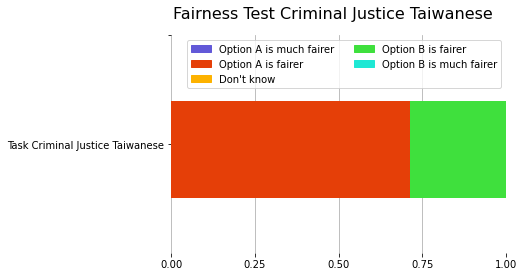

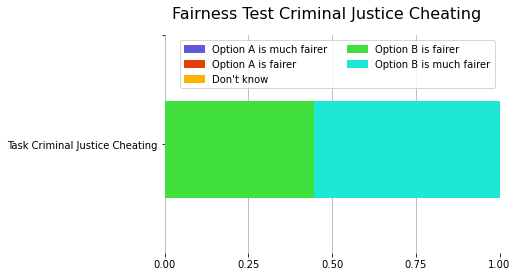

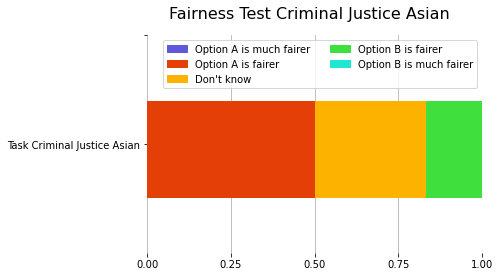

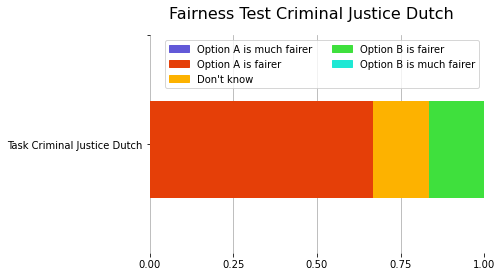

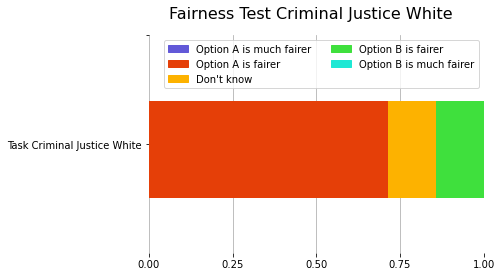

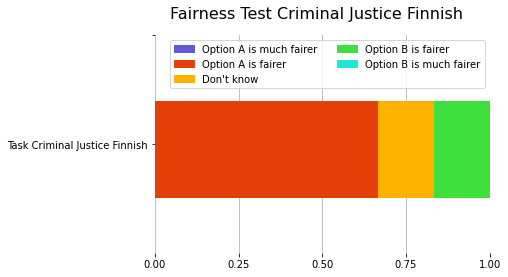

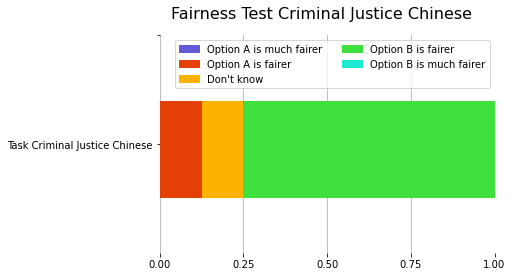

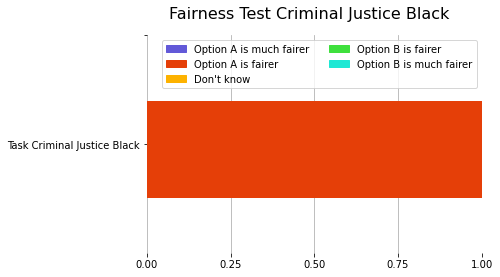

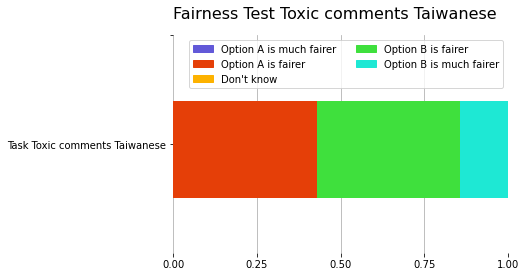

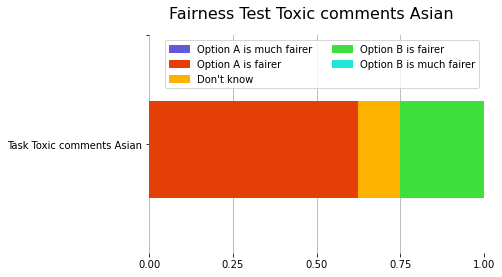

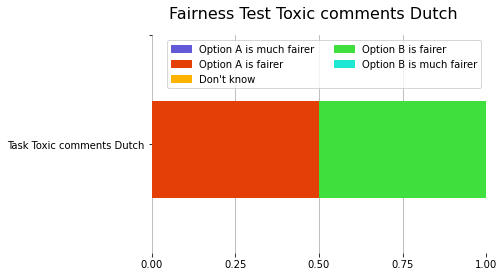

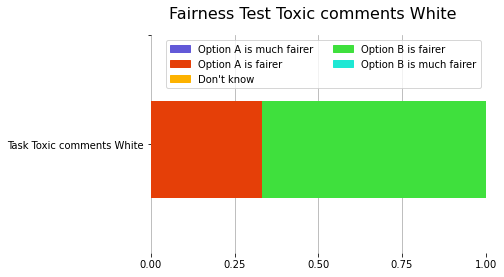

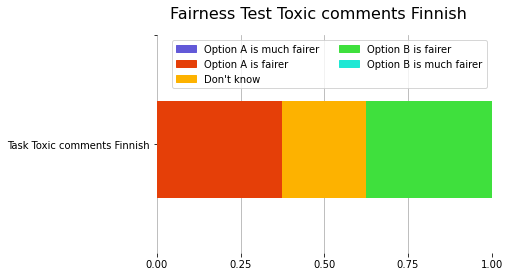

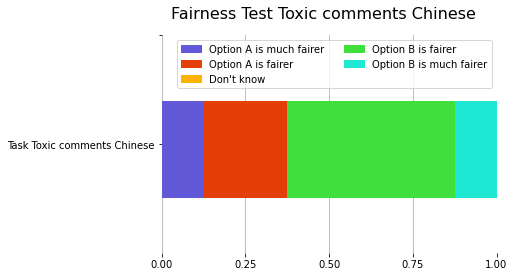

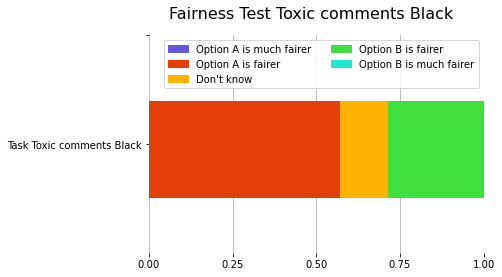

In [155]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#Function for plotting the fairness of models according to workers 
def plot_fairness(task, filt_country, filt_race):
    prefer_A = 0
    prefer_A_l = 0
    dont_know = 0
    prefer_B_l = 0
    prefer_B = 0

    num_passed = 0
    for worker_id in ids:
        pass_country = True
        if filt_country:
            pass_country = False
            for filt in filt_country:
                if countries[worker_id] == filt:
                    pass_country = True             
        
        pass_race = True
        if filt_race:
            pass_race = False        
            for filt in filt_race:
                if races[worker_id] == filt:
                    pass_race = True      
            
        if pass_country and pass_race:
            if task in task_answers[worker_id]:
                num_passed += 1
                x = task_answers[worker_id][task]
                if x == opt1:
                    prefer_A += 1 
                if x == opt2:
                    prefer_A_l += 1
                if x == opt3:
                    dont_know += 1
                if x == opt4:
                    prefer_B_l += 1
                if x == opt5:
                    prefer_B += 1
                    
    prefer_A = prefer_A / num_passed
    prefer_A_l = prefer_A_l / num_passed
    dont_know = dont_know / num_passed
    prefer_B_l = prefer_B_l / num_passed
    prefer_B = prefer_B / num_passed
    
    #print(num_passed)
    #print(prefer_A)
    #print(prefer_A_l)
    #print(dont_know)
    #print(prefer_B_l)
    #print(prefer_B)

    fig, ax = plt.subplots()
    ax.broken_barh([(0, prefer_A), 
                    (prefer_A, prefer_A+prefer_A_l), 
                    (prefer_A+prefer_A_l, 
                     prefer_A+prefer_A_l+dont_know),
                    (prefer_A+prefer_A_l+dont_know, 
                     prefer_A+prefer_A_l+dont_know+prefer_B_l),
                    (prefer_A+prefer_A_l+dont_know+prefer_B_l,
                     prefer_A+prefer_A_l+dont_know+prefer_B_l+prefer_B)], [10, 9], 
                     facecolors=('#6259D8', '#E53F08', '#FDB200', '#3FE03D', '#1EE8D4'))

    ax.set_ylim(5, 15)
    ax.set_xlim(0, 1)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([15, 25])
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    ax.set_axisbelow(True) 
    
    ax.set_yticklabels(['Task ' + task])
    ax.grid(axis='x')
    
    
    fig.suptitle('Fairness Test ' + task, fontsize=16)

    leg1 = mpatches.Patch(color='#6259D8', label=opt1)
    leg2 = mpatches.Patch(color='#E53F08', label=opt2)
    leg3 = mpatches.Patch(color='#FDB200', label=opt3)
    leg4 = mpatches.Patch(color='#3FE03D', label=opt4)
    leg5 = mpatches.Patch(color='#1EE8D4', label=opt5)
    ax.legend(handles=[leg1, leg2, leg3, leg4, leg5], ncol=2)

    plt.show()
    
for task in tasks:
    plot_fairness(task, [], [])

In [185]:
import sklearn.metrics as met

#Function for calculating agreement of between people
#can filter out certain races and nationalities
def calculate_agreement(filt_country1, filt_race1, filt_country2, filt_race2):
    workers1 = []
    answers1_tox = {}
    answers1_cri = {}
    for worker_id in ids:
        pass_country = True
        if filt_country1:
            pass_country = False
            for filt in filt_country1:
                if countries[worker_id] == filt:
                    pass_country = True             

        pass_race = True
        if filt_race1:
            pass_race = False        
            for filt in filt_race1:
                if races[worker_id] == filt:
                    pass_race = True  

        if pass_country and pass_race:           
            workers1.append(worker_id)
            answers_tasks_cri = []
            answers_tasks_tox = []
            for task in tasks:
                if task in tasks_cri:
                    if task in task_answers[worker_id].keys():
                        answers_tasks_cri.append(task_answers[worker_id][task])
                    else:
                        answers_tasks_cri.append("")
                else:
                    if task in task_answers[worker_id].keys():
                        answers_tasks_tox.append(task_answers[worker_id][task])
                    else:
                        answers_tasks_tox.append("")
                        
            answers1_cri[worker_id] = answers_tasks_cri
            answers1_tox[worker_id] = answers_tasks_tox 
                    
            
    workers2 = []
    answers2_tox = {}
    answers2_cri = {}
    for worker_id in ids:
        pass_country = True
        if filt_country2:
            pass_country = False
            for filt in filt_country2:
                if countries[worker_id] == filt:
                    pass_country = True             

        pass_race = True
        if filt_race2:
            pass_race = False        
            for filt in filt_race2:
                if races[worker_id] == filt:
                    pass_race = True  

        if pass_country and pass_race:           
            workers2.append(worker_id)
            answers_tasks_cri = []
            answers_tasks_tox = []
            for task in tasks:
                if task in tasks_cri:
                    if task in task_answers[worker_id].keys():
                        answers_tasks_cri.append(task_answers[worker_id][task])
                    else:
                        answers_tasks_cri.append("")
                else:
                    if task in task_answers[worker_id].keys():
                        answers_tasks_tox.append(task_answers[worker_id][task])
                    else:
                        answers_tasks_tox.append("")
                        
            answers2_cri[worker_id] = answers_tasks_cri
            answers2_tox[worker_id] = answers_tasks_tox 
    
    
    agreement_score = 0
    num_comparisons = 0
    for worker1 in workers1:
        for worker2 in workers2:
            if worker1 != worker2:
                answers1 = []
                answers2 = []
                for i in range(len(answers2_cri[worker2])):
                    if answers1_cri[worker1][i] != "" and answers2_cri[worker2][i] != "":
                        answers1.append(answers1_cri[worker1][i])
                        answers2.append(answers2_cri[worker2][i])
                    else:   
                        continue
                if len(answers1) > 1 and len(answers2) > 1:
                    agr = met.cohen_kappa_score(answers1, answers2, labels=[opt1,opt2,opt2,opt4,opt5])
                    agreement_score += agr
                    num_comparisons += 1
                    #print("The inter annotator score bewteen on criminal justice tasks " 
                    #      + worker1 + " and " + worker2 + " is: " + str(agr))
                   
    agreement_score = agreement_score/num_comparisons    
    
    print("The average inter annotator score on criminal justice tasks between people with the following demographics" 
          + str(filt_country1) + str(filt_race1) + " and " +  str(filt_country2) + str(filt_race2) 
          + ": " + str(agreement_score))
    
    agreement_score = 0
    num_comparisons = 0
    for worker1 in workers1:
        for worker2 in workers2:
            if worker1 != worker2:
                answers1 = []
                answers2 = []
                for i in range(len(answers2_tox[worker2])):
                    if answers1_tox[worker1][i] != "" and answers2_tox[worker2][i] != "":
                        answers1.append(answers1_tox[worker1][i])
                        answers2.append(answers2_tox[worker2][i])
                    else:   
                        continue
                
                if len(answers1) > 1 and len(answers2) > 1:
                    agr = met.cohen_kappa_score(answers1, answers2, labels=[opt1,opt2,opt2,opt4,opt5])
                    agreement_score += agr
                    num_comparisons += 1
                    #print("The inter annotator score bewteen on toxic comment tasks " 
                    #      + worker1 + " and " + worker2 + " is: " + str(agr))
                   
    agreement_score = agreement_score/num_comparisons 
    
    print("The average inter annotator score on toxic comments tasks between people with the following demographics" 
          + str(filt_country1) + str(filt_race1) + " and " +  str(filt_country2) + str(filt_race2) 
          + ": " + str(agreement_score))
    
calculate_agreement([], [], [], [])
calculate_agreement(["Finland"], ["White"], ["Finland"], ["White"])

The average inter annotator score on criminal justice tasks between people with the following demographics[][] and [][]: 0.37382837070337077
The average inter annotator score on toxic comments tasks between people with the following demographics[][] and [][]: -0.12442455012919788
The average inter annotator score on criminal justice tasks between people with the following demographics['Finland']['White'] and ['Finland']['White']: -0.09595959595959597
The average inter annotator score on toxic comments tasks between people with the following demographics['Finland']['White'] and ['Finland']['White']: -0.6551724137931035


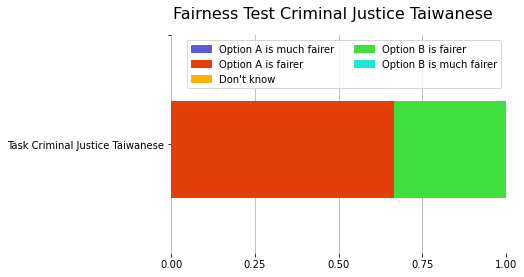

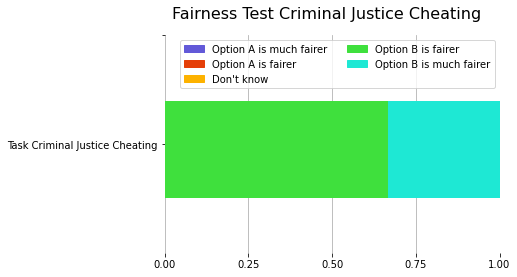

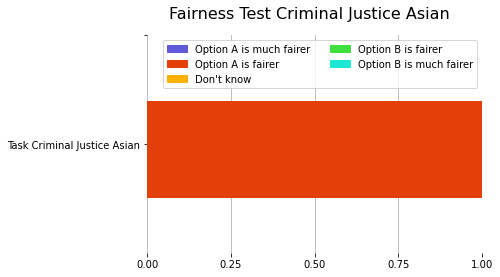

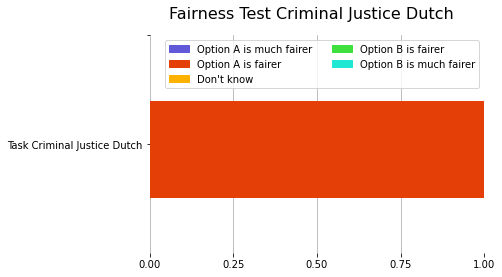

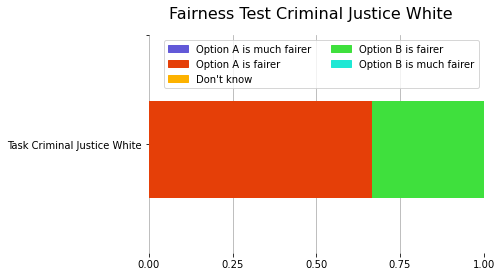

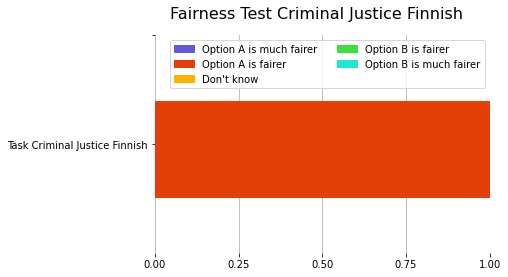

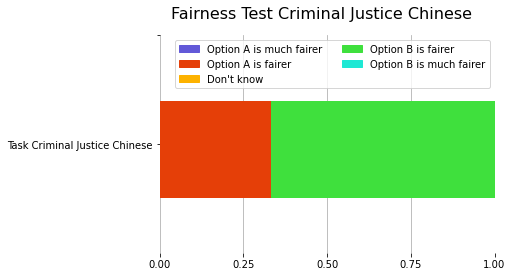

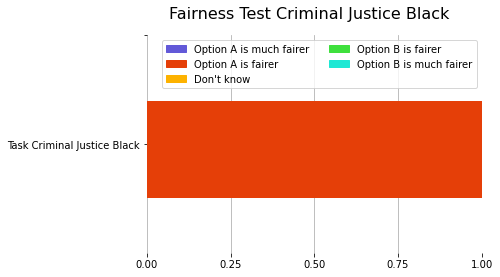

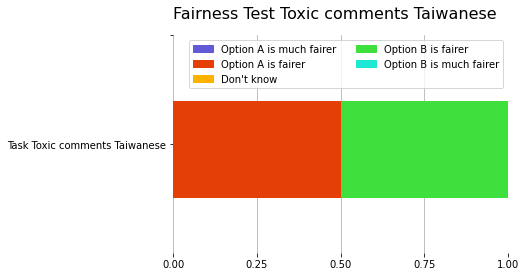

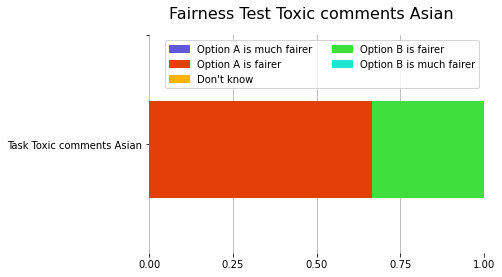

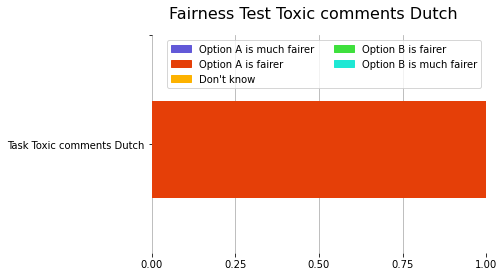

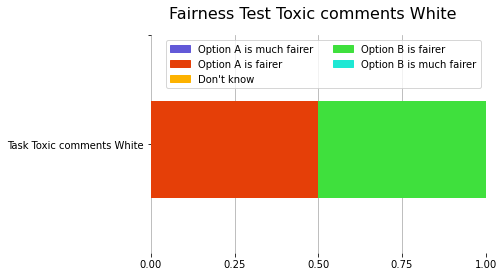

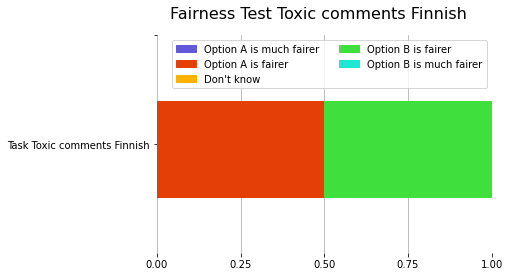

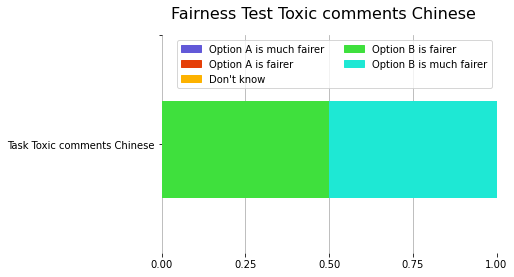

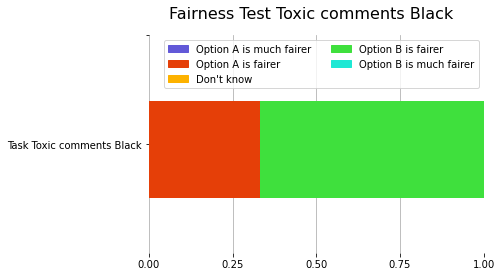

In [159]:
#Plot for Finnish Christian
#To filter out demographics: 
#the first list is to only allow people from certain countries
#the second list is to only allow people with certain religions
#the third list is to only allow people with certain races
#Empty lists means every demograhic is allowed
for task in tasks:
    plot_fairness(task, ["Finland"], ["White"])
